# Modèle QANet pour du *Question Answering*
Base de données: https://rajpurkar.github.io/SQuAD-explorer/

## Importation des données

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

### Extraction des variables de texte et des indices des réponses à l'aides d'outils de NLP

In [4]:
import IPython.display

import re as regex
import spacy
nlp = spacy.load('fr_core_news_sm')

def traitement_nlp(text):
    ctxt = regex.sub(r'[^0-9 ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzäëïöüâêîôûàéêèçùÉÀÈÇÂÊÎÔÛÄËÏÖÜÀÇÉÈÙ,:.?!;\[\]\(\)\'-]','', text) # traitement ici pour optimiser
    ctxt = regex.sub(r"\[[^\[\]]*\]",'',ctxt) # enlever les brackets et leur contenu
    ctxt = regex.sub(r'[" "]+', " ", ctxt) # remplacer les surplus d'espaces par uniquement un espace
    ll = [tok.text.lower() for tok in nlp(ctxt)]
    ctxt = ' '.join(ll)
    return ctxt,ll

#### Restaurer la liste du dataset

In [5]:
import pickle
with open("./questions_réponses_scol", "rb") as fp:   # Unpickling
    dataset = pickle.load(fp)

#### Création des tenseurs en entrée et sortie
* 1) contexte et question à l'aide de l'outil de TF de tokénisation

In [6]:
list_contexts = [data[0] for data in dataset]
list_questions = [data[1] for data in dataset]


from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters='')
# créer un tokenizer adapté à tout le vocabulaire des questions et réponses (indexation valide sur les 2)
tokenizer.fit_on_texts(list_contexts + list_questions) 


tensor_context = tokenizer.texts_to_sequences(list_contexts)
tensor_question = tokenizer.texts_to_sequences(list_questions)

# Pad the tensors to assign equal length to all the sequences
tensor_context = tf.keras.preprocessing.sequence.pad_sequences(tensor_context,padding='post')
tensor_question = tf.keras.preprocessing.sequence.pad_sequences(tensor_question,padding='post')


# Show the mapping b/w word index and language tokenizer
def convert(tokenizer, tensor):
    for t in tensor: # t est un entier élément du tenseur
        if t != 0:
            print ("%d ----> %s" % (t, tokenizer.index_word[t]))
convert(tokenizer, tensor_question[0])

print(list_questions[0])
print(tensor_question[0])

32 ----> qui
828 ----> approuve
7 ----> le
140 ----> règlement
1 ----> de
41 ----> scolarité
11 ----> ?
Qui approuve le règlement de scolarité ?
[ 32 828   7 140   1  41  11   0   0   0   0   0   0   0   0   0   0   0
   0   0]


* 2) réponse avec les vecteurs de probas de start et stop complets

In [7]:
tensor_answer_start = np.zeros(tensor_context.shape)
tensor_answer_stop  = np.zeros(tensor_context.shape)
for i in range(len(dataset)):
    tensor_answer_start[i][dataset[i][3]] = 1 # mettre une "proba" 1 là où ça démarre
    tensor_answer_stop[i][dataset[i][4]]  = 1 # mettre une "proba" 1 là où ça stoppe

tensor_answer_start = tf.convert_to_tensor(tensor_answer_start,dtype=tf.int32)
tensor_answer_stop = tf.convert_to_tensor(tensor_answer_stop,dtype=tf.int32)


Vérification des tailles des 4 tenseurs d'intérêt (2 en entrée, 2 en sortie)

In [8]:
print(tensor_context.shape, tensor_context.dtype)
print(tensor_question.shape, tensor_question.dtype)
print(tensor_answer_start.shape, tensor_answer_start.dtype)

(102, 185) int32
(102, 20) int32
(102, 185) <dtype: 'int32'>


### Quelques paramètres importants

In [9]:
vocab_inp_size = len(tokenizer.word_index)
n_train, max_length_question = tensor_question.shape
nb_set_train, max_length_context = tensor_context.shape
embedding_dim = 32

print(f"nombre de données: {n_train}\nlongueur max contexte en mots: {max_length_context}\nlongueur max question en mots: {max_length_question}\ntaille du vocabulaire: {vocab_inp_size}")

nombre de données: 102
longueur max contexte en mots: 185
longueur max question en mots: 20
taille du vocabulaire: 898


## Création des classes pertinentes
### Positional encoding
#### **[OK]** Classe `PositionalEncoding` du livre de François Chollet

In [10]:
class PositionalEncoding(tf.keras.layers.Layer): # dans Hands-On Machine Learning for Python
    def __init__(self, sizes, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        max_steps = sizes[0]
        max_dims = sizes[1]
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]
    def get_config(self):
        config = super().get_config()
        config.update({})
        return config

#### **[OK]** Classe `EncoderBlock`

In [34]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, dimension, maximum_position_encoding, nb_att_heads):
        super(EncoderBlock, self).__init__()
        self.dim_embedding = dimension
        self.pos_encoding = PositionalEncoding([maximum_position_encoding,dimension])

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=nb_att_heads, key_dim=dimension)

        # feed-forward network
        self.ffn = tf.keras.layers.Dense(dimension, activation='tanh')
        

        self.cnn = tf.keras.layers.Conv1D(filters=dimension,kernel_size=4,padding='same')  # Use 'same' padding so outputs have the same shape as inputs.

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.add1 = tf.keras.layers.Add()
        self.add2 = tf.keras.layers.Add()
        self.add3 = tf.keras.layers.Add()

        self.dropout1 = tf.keras.layers.Dropout(.03)
        self.dropout2 = tf.keras.layers.Dropout(.03)
        self.dropout3 = tf.keras.layers.Dropout(.03)

    def call(self, x):

        x_enc = self.pos_encoding(x)
        
        out_norm1     = self.norm1(x_enc)
        out_conv      = self.cnn(out_norm1)
        out1          = self.add1([out_conv,x])
        out1          = self.dropout1(out1)

        out_norm2     = self.norm2(out1)
        out_att       = self.mha(out_norm2, out_norm2, out_norm2, return_attention_scores=False)
        out2          = self.add2([out_att,out1])
        out2          = self.dropout2(out2)

        out_norm3     = self.norm3(out2)
        out_ffn       = self.ffn(out_norm3)
        out3          = self.add3([out_ffn,out2])
        out3          = self.dropout2(out3)

        return out3

### Pour faire un schéma de l'Encoder Block

In [12]:
mha = tf.keras.layers.MultiHeadAttention(num_heads=3, key_dim=128, name='attention')

# feed-forward network
ffn1 = tf.keras.layers.Dense(128, activation='tanh', name='feed_forward_1')  # (batch_size, seq_len, dff)
ffn2 = tf.keras.layers.Dense(128, activation='tanh', name='feed_forward_2')  # (batch_size, seq_len, dimension)


cnn = tf.keras.layers.Conv1D(filters=128,kernel_size=4,padding='same', name='convolution')   # Use 'same' padding so outputs have the same shape as inputs.

norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

add1 = tf.keras.layers.Add()
add2 = tf.keras.layers.Add()
add3 = tf.keras.layers.Add()

pos_enc = PositionalEncoding([20, 128])


x = tf.keras.Input(shape=(10,128))


out_enc = pos_enc(x)


out_norm1     = norm1(out_enc)
out_conv      = cnn(out_norm1)
out1          = add1([out_conv,out_enc])

out_norm2     = norm2(out1)
out_att       = mha(out_norm2, out_norm2, out_norm2, return_attention_scores=False)
out2          = add2([out_att,out1])

out_norm3     = norm3(out2)
out_ffn1      = ffn1(out_norm3)
out_ffn2      = ffn2(out_ffn1)
out3          = add3([out_ffn2,out2])

func_model = tf.keras.Model(inputs=x, outputs=out3)

inp_example = tf.random.normal((4,10,128), mean=0.0, stddev=1.0, dtype=tf.float32)
print(func_model(inp_example).shape)

func_model.compile()
func_model.summary()

(4, 10, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 128)]    0           []                               
                                                                                                  
 positional_encoding (Positiona  (None, 10, 128)     0           ['input_1[0][0]']                
 lEncoding)                                                                                       
                                                                                                  
 layer_normalization (LayerNorm  (None, 10, 128)     256         ['positional_encoding[0][0]']    
 alization)                                                                                       
                                                                                 

In [27]:
tf.keras.utils.plot_model(func_model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

NameError: name 'func_model' is not defined

#### Classe `QARetriever`

In [35]:
class QARetriever(tf.keras.Model):
    def __init__(self, dimension_embedding, maximum_position_encoding, nb_att_heads, vocab_size):
        super().__init__()

        self.encoder_block_context = EncoderBlock(dimension=dimension_embedding,
                                                  maximum_position_encoding=maximum_position_encoding,
                                                  nb_att_heads=nb_att_heads)
        self.encoder_block_question = EncoderBlock(dimension=dimension_embedding,
                                                  maximum_position_encoding=maximum_position_encoding,
                                                  nb_att_heads=nb_att_heads)

        self.encoder_block1 = EncoderBlock(dimension=dimension_embedding,
                                                  maximum_position_encoding=maximum_position_encoding,
                                                  nb_att_heads=nb_att_heads)
        self.encoder_block2 = EncoderBlock(dimension=dimension_embedding,
                                                  maximum_position_encoding=maximum_position_encoding,
                                                  nb_att_heads=nb_att_heads)
        self.encoder_block3 = EncoderBlock(dimension=dimension_embedding,
                                                  maximum_position_encoding=maximum_position_encoding,
                                                  nb_att_heads=nb_att_heads)



        self.embedding_layer      = tf.keras.layers.Embedding(vocab_size, dimension_embedding)
        self.mask                 = tf.keras.layers.Masking(mask_value=0, input_shape=(None, maximum_position_encoding, embedding_dim))
        self.attention_layer      = tf.keras.layers.Attention()
        self.concat_layer         = tf.keras.layers.Concatenate(axis=-2) # concatenate sequences, not features
        self.dense_start          = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
        self.dense_stop           = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
        self.dense_start_final    = tf.keras.layers.Dense(maximum_position_encoding, activation=tf.keras.activations.linear)
        self.dense_stop_final     = tf.keras.layers.Dense(maximum_position_encoding, activation=tf.keras.activations.linear)


    def call(self, inputs):
        # Keras models prefer if you pass all your inputs in the first argument

        context, question    = inputs
        question_embedding   = self.embedding_layer(question) # (batch_size, inp_seq_len, d_model)
        question_embedding   = self.mask(question_embedding)
        context_embedding    = self.embedding_layer(context)
        context_embedding    = self.mask(context_embedding)

        pre_att_question = self.encoder_block_question(question_embedding)
        pre_att_context = self.encoder_block_context(context_embedding)

        ctxt_query_att = self.attention_layer([pre_att_context, pre_att_question])

        out1 = self.encoder_block1(ctxt_query_att)
        out2 = self.encoder_block2(out1)
        out3 = self.encoder_block3(out2)

        
        input_start = self.concat_layer([out1, out2])
        input_stop = self.concat_layer([out1, out3])
        # print(f"input dense: {input_start.shape}")

        output_start = self.dense_start(input_start)
        output_stop = self.dense_stop(input_stop)
        # print(f"output dense: {output_start.shape}")

        output_start = tf.squeeze(output_start, axis=-1)
        output_stop = tf.squeeze(output_stop, axis=-1)
        # print(f"output dense + squeeze: {output_start.shape}")

        # enfin, on réduit la dimension à la longueur originale
        output_start = self.dense_start_final(output_start)
        output_stop  = self.dense_stop_final(output_stop)
        # print(f"output dense final: {output_start.shape}")



        prob_start = tf.nn.softmax(output_start, axis=-1)
        prob_stop = tf.nn.softmax(output_stop, axis=-1)

        return prob_start,prob_stop


In [36]:
retriever = QARetriever(dimension_embedding=embedding_dim, maximum_position_encoding=max_length_context, nb_att_heads=3, vocab_size=vocab_inp_size)
retriever.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(), metrics = ["accuracy"]) # losses.MeanSquaredError() losses.CosineSimilarity()
retriever.build(input_shape=[tensor_context.shape, tensor_question.shape])
retriever.summary()
# retriever = retriever.get_model()
# retriever.save('./saved_model/qanet',save_format='tf')

Model: "qa_retriever_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_block_20 (EncoderBl  multiple                 17984     
 ock)                                                            
                                                                 
 encoder_block_21 (EncoderBl  multiple                 17984     
 ock)                                                            
                                                                 
 encoder_block_22 (EncoderBl  multiple                 17984     
 ock)                                                            
                                                                 
 encoder_block_23 (EncoderBl  multiple                 17984     
 ock)                                                            
                                                                 
 encoder_block_24 (EncoderBl  multiple              

Afficher les métriques disponibles

In [37]:
history = retriever.fit([tensor_context, tensor_question],[tensor_answer_start,tensor_answer_stop],
                epochs=100,
                batch_size=n_train, # on a pas bcp de données alors un batch peut tout prendre à la fois
                shuffle=True,
                #validation_data=([tensor_context, tensor_question],[tensor_answer_start,tensor_answer_stop]),
                validation_split=0.2,
                verbose=1)

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 18.9544 - output_1_loss: 10.5102 - output_2_loss: 8.4443 - output_1_accuracy: 0.0000e+00 - output_2_accuracy: 0.0000e+00 - val_loss: 15.2373 - val_output_1_loss: 6.6867 - val_output_2_loss: 8.5506 - val_output_1_accuracy: 0.0000e+00 - val_output_2_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 158ms/step - loss: 15.9697 - output_1_loss: 7.5274 - output_2_loss: 8.4422 - output_1_accuracy: 0.0000e+00 - output_2_accuracy: 0.0000e+00 - val_loss: 13.3604 - val_output_1_loss: 7.9431 - val_output_2_loss: 5.4173 - val_output_1_accuracy: 0.0000e+00 - val_output_2_accuracy: 0.0476
Epoch 3/100
1/1 [==============================] - 0s 154ms/step - loss: 14.0921 - output_1_loss: 8.0019 - output_2_loss: 6.0902 - output_1_accuracy: 0.0000e+00 - output_2_accuracy: 0.0247 - val_loss: 11.6265 - val_output_1_loss: 6.2258 - val_output_2_loss: 5.4007 - val_output_1_accuracy: 0.0000e+00 - val_output_2_accuracy

In [37]:
# retriever.save_weights('./checkpoints/retriever_QAnet_20000')

In [38]:
# Restore the weights
# retriever.load_weights('./checkpoints/retriever_QAnet_20000')

Montrer les courbes d'apprentissage du modèle

In [31]:
history.history.keys()

dict_keys(['loss', 'output_1_loss', 'output_2_loss', 'output_1_accuracy', 'output_2_accuracy', 'val_loss', 'val_output_1_loss', 'val_output_2_loss', 'val_output_1_accuracy', 'val_output_2_accuracy'])

Faire le plot

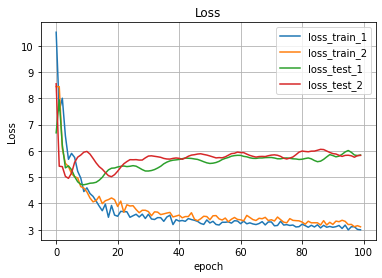

In [38]:
plt.figure(1)
plt.plot(history.history['output_1_loss'])
plt.plot(history.history['output_2_loss'])
plt.plot(history.history['val_output_1_loss'])
plt.plot(history.history['val_output_2_loss'])
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(['loss_train_1', 'loss_train_2', 'loss_test_1', 'loss_test_2'], loc='best')
plt.savefig('loss.pdf')

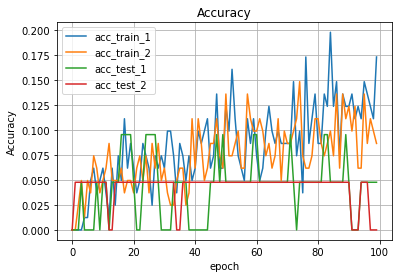

In [39]:
plt.figure(1)
plt.plot(history.history['output_1_accuracy'])
plt.plot(history.history['output_2_accuracy'])
plt.plot(history.history['val_output_1_accuracy'])
plt.plot(history.history['val_output_2_accuracy'])
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(['acc_train_1', 'acc_train_2', 'acc_test_1', 'acc_test_2'], loc='best')
plt.savefig('accuracy.pdf')

In [103]:
def prediction_dataset(indice_test,dataset,tensor_context,tensor_question):
    print(dataset[indice_test])
    acc = [tf.expand_dims(tensor_context[indice_test,:], axis=0),tf.expand_dims(tensor_question[indice_test,:], axis=0)]
    res = retriever.predict(acc)
    #print(res[0].shape,res[1].shape)

    ind_start_pred = tf.math.argmax(res[0][0])
    ind_stop_pred = tf.math.argmax(res[1][0])
    print(f"prédiction proba start: {ind_start_pred}")
    print(f"prédiction proba stop:  {ind_stop_pred}")
    return ' '.join(dataset[indice_test][0].split(' ')[ind_start_pred:ind_stop_pred]) # on affiche la réponse en toutes lettres

In [104]:
prediction_dataset(0,dataset,tensor_context,tensor_question)

["Le Règlement de Scolarité est approuvé par le Conseil d' Administration de l' École après consultation du Conseil des Études .", 'Qui approuve le règlement de scolarité ?', "Conseil d' Administration de l' École", 8, 14]
prédiction proba start: 8
prédiction proba stop:  14


"Conseil d' Administration de l' École"

In [153]:
print("Données d'entraînement:")
print(tensor_context.shape)
print(tensor_question.shape)

ctxt = ["L'élève doit passer l'examen de seconde session si le directeur le décide pour valider sa mobilité."]
qu   = ["Qui doit passer un examen de seconde session ?"]
ctxt_tra = [traitement_nlp(ar) for ar in ctxt]
qu_tra   = [traitement_nlp(br) for br in qu]

ctxt_ind = [g[0] for g in ctxt_tra]
qu_ind   = [g[0] for g in qu_tra]

ctxt_test = tokenizer.texts_to_sequences(ctxt_ind)
qu_test = tokenizer.texts_to_sequences(qu_ind)
for qu in qu_test:
    qu += (tensor_question.shape[1]-len(qu))*[0]
for ctxt in ctxt_test:
    ctxt += (tensor_context.shape[1]-len(ctxt))*[0]

tensor_context_test = tf.keras.preprocessing.sequence.pad_sequences(ctxt_test,padding='post')
tensor_question_test = tf.keras.preprocessing.sequence.pad_sequences(qu_test,padding='post')
print("données test:")
print(tensor_context_test.shape)
print(tensor_question_test.shape)

Données d'entraînement:
(102, 185)
(102, 20)
données test:
(1, 185)
(1, 20)


In [154]:
res = retriever.predict([tensor_context_test,tensor_question_test])
j = 0 # indice du couple dans le batch qu'on prédit
ind_start_pred = tf.math.argmax(res[0][j])
ind_stop_pred = tf.math.argmax(res[1][j])
print(f"prédiction proba start: {ind_start_pred}")
print(f"prédiction proba stop:  {ind_stop_pred}")
reponse = ' '.join(ctxt_tra[j][0].split(' ')[ind_start_pred:ind_stop_pred+1]) # +1 car semi ouvert en python et l'entraînement prenait l'indice réel
reponse

prédiction proba start: 4
prédiction proba stop:  8


"l' examen de seconde session"

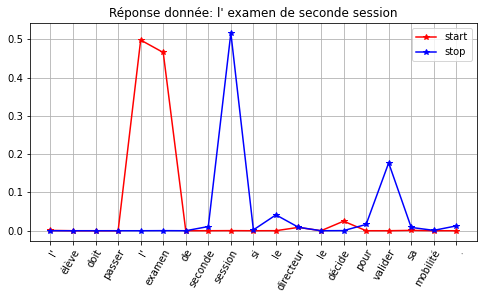

In [160]:
length_ctxt = len(ctxt_tra[j][1])
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(range(length_ctxt),np.array(res[0][j])[:length_ctxt],color='red',label='start',marker='*') # 0 pour ind start
plt.plot(range(length_ctxt),np.array(res[1][j])[:length_ctxt],color='blue',label='stop',marker='*') # 1 pour ind stop
ax.set_xticks(range(length_ctxt))
ax.set_xticklabels(ctxt_tra[j][1])
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.legend()
plt.title(f"Réponse donnée: {reponse}")
plt.grid(True)
plt.savefig('prediction.pdf', bbox_inches='tight')
plt.show()